In [1]:
import sys 
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.rosetta.protocols.carbohydrates import *
from pyrosetta.rosetta.core.pose import *
from pyrosetta.rosetta.core.scoring import *
from pyrosetta.rosetta.protocols.minimization_packing import *
from pyrosetta.rosetta.core.pose.carbohydrates import glycosylate_pose, glycosylate_pose_by_file
from pyrosetta.rosetta.protocols.carbohydrates import SimpleGlycosylateMover
from pyrosetta.rosetta.protocols.rosetta_scripts import *

## Personal Imports
import basePeptidePrep
import addBaseSugarAndEnzyme

## Pyrosetta Initialization
pyrosetta.init('-include_sugars -write_pdb_link_records -ex1 -ex2 -alternate_3_letter_codes pdb_sugar -auto_detect_glycan_connections -min_bond_length 1.1 -max_bond_length 1.5 -ignore_zero_occupancy false -ignore_unrecognized_res false')

## Command Line Arguments 
'''
Command Line Arguments:
# For the base peptide 
- Sequence of the base peptide (2-3 AA long peptides are ideal) : base_seq
- Position of the sequence containing THR that will be glycosylated : base_pos
- the sugar that will be glycosylated on the base peptide : base_sugar

# input pdb files
- The enzyme with donor peptide 

- The constraint file

'''
base_seq = "STP"
base_position = 2
base_sugar = "core1"
input_enzyme_file = "/home/souvadra/myGitFolders/Glycosyltransferase/glycan_sampler_pipeline/output_3OTK-closed-S217C/3OTK-closed-monomer-alpha-GlcNAc-S217C_0005.pdb"
constraints_file = "constraints_file.cst"
#constraints_file = "trialConstraint.cst"
## Prepare the base peptide 
base_pose = basePeptidePrep.basePeptideBuild(base_seq, base_position, base_sugar)

## Addition of peptide and sugar motif 
enzyme_pose = pose_from_pdb(input_enzyme_file)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.40+release.f01fa77e7385c2c0bdac6e346b24a6d8d900e7c7 2020-10-02T11:47:11] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release r267 2020.40+release.f01fa77 f01fa77e7385c2c0bdac6e346b24a6d8d900e7c7 http://www.pyrosetta.org 2020-10-02T11:47:11
core.init: {0} command: PyRosetta -include_sugars -write_pdb_link_records -ex1 -ex2 -alternate_3_letter_codes pdb_sugar -auto_detect_glycan_connections -min_bond_length 1.1 -max_bond_length 1.5 -ignore_zero_occupancy false -ignore_unrecognized_res false -database /home/souvadra/anaconda3/envs/pyrosetta_env/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator:

protocols.carbohydrates.GlycanSampler: {0} Randomizing glycan torsions
protocols.carbohydrates.GlycanSampler: {0} Modeling 2 glycan residues
protocols.carbohydrates.GlycanSampler: {0} Setting up Tree-based packing.
protocols.carbohydrates.GlycanSampler: {0} Initialized
protocols.carbohydrates.GlycanSampler: {0} starting energy: 5447.33
protocols.carbohydrates.GlycanSampler: {0} Total Rounds = 200 ( 2 glycans * 100 )
protocols.carbohydrates.LinkageConformerMover: {0} Sampling beta-D-Galp-(?->3)-alpha-D-GalpNAc- linkage
protocols.carbohydrates.LinkageConformerMover: {0} Sampling conformer 1 which has a population of 1
protocols.carbohydrates.LinkageConformerMover: {0} Complete
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.carbohydrates.GlycanSampler: {0} Last mover failed.  Continueing!
protocols.carbohydrates.LinkageConformerMover: {0} Sampling ->3)-alpha-D-GalpNAc-(?THR linkage
protocols.carbohydrates.LinkageConformerMover: {0} Samp

protocols.carbohydrates.LinkageConformerMover: {0} Sampling ->3)-alpha-D-GalpNAc-(?THR linkage
protocols.carbohydrates.LinkageConformerMover: {0} Sampling conformer 1 which has a population of 1
protocols.carbohydrates.LinkageConformerMover: {0} Complete
protocols.carbohydrates.LinkageConformerMover: {0} Sampling beta-D-Galp-(?->3)-alpha-D-GalpNAc- linkage
protocols.carbohydrates.LinkageConformerMover: {0} Sampling conformer 1 which has a population of 1
protocols.carbohydrates.LinkageConformerMover: {0} Complete
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSet_: {0} [ WARNING ] including current in order to get at least 1 rotamer !!!!!! 2 THR:O-conjugated
core.pack.pack_rotamers: {0} built 460 rotamers at 4 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.Rotamer

protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.carbohydrates.GlycanSampler: {0} Last mover failed.  Continueing!
protocols.carbohydrates.GlycanTreeMinMover: {0} Minimizing from carbohydrate root: 4
protocols.carbohydrates.GlycanTreeMinMover: {0} Minimizing 2 residues
protocols.carbohydrates.LinkageConformerMover: {0} Sampling beta-D-Galp-(?->3)-alpha-D-GalpNAc- linkage
protocols.carbohydrates.LinkageConformerMover: {0} Sampling conformer 1 which has a population of 1
protocols.carbohydrates.LinkageConformerMover: {0} Complete
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 405 rotamers at 2 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avail

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSet_: {0} [ WARNING ] including current in order to get at least 1 rotamer !!!!!! 2 THR:O-conjugated
core.pack.pack_rotamers: {0} built 406 rotamers at 3 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
protocols.carbohydrates.GlycanSampler: {0} Round: 140
protocols.carbohydrates.GlycanTreeMinMover: {0} Minimizing from carbohydrate root: 5
protocols.carbohydrates.GlycanTreeMinMover: {0} Minimizing 1 residues
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_

protocols.carbohydrates.LinkageConformerMover: {0} Complete
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSet_: {0} [ WARNING ] including current in order to get at least 1 rotamer !!!!!! 2 THR:O-conjugated
core.pack.pack_rotamers: {0} built 406 rotamers at 3 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
protocols.carbohydrates.GlycanSampler: {0} Round: 190
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSet_: {0} [ WARNING ] including current in order to get at least 1 rotamer !!!!!! 2 THR:O-conjugated
core.pack.pack_rotamers: {0} built 406 rotamers at 3 positions.
core.pack.pack_rotamers: {0} Requesting all av

protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.

protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.simple_moves.BackboneMover: {0} [ WARNING ] no movable positions in ShearMover!
protocols.

In [2]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.rosetta.protocols.carbohydrates import *
from pyrosetta.rosetta.core.pose import *
from pyrosetta.rosetta.core.scoring import *
from pyrosetta.rosetta.protocols.minimization_packing import *
from pyrosetta.rosetta.core.pose.carbohydrates import glycosylate_pose, glycosylate_pose_by_file
from pyrosetta.rosetta.protocols.carbohydrates import SimpleGlycosylateMover
from pyrosetta.rosetta.protocols.rosetta_scripts import *

from pyrosetta.rosetta.core.scoring.constraints import *
from pyrosetta.rosetta.core.select.movemap import MoveMapFactory

def mergePoses(base_pose, enzyme_pose):
    """merge the base pose into enzyme pose without making any covalent bond"""
    anchor_point = int(enzyme_pose.total_residue()) - 2 # just to make sure that the UDP-sugar remains the last residues in the whole pose
    enzyme_pose.append_pose_by_jump(base_pose, anchor_point)

""" This program takes the base sugar pose and the pose of the enzyme with donor moiety
     and the constraints and make sure the they obey the constraint in subsequent relax
       procedure as a procedure to bypass manual overlaying using PyMOL. """
init("-constraints:cst_fa_file " + constraints_file)

sfxn = pyrosetta.create_score_function("ref2015_cart.wts") #get_fa_scorefxn()
initial_energy = sfxn(enzyme_pose)
# merging two poses to form one 
mergePoses(base_pose, enzyme_pose)

sfxn.set_weight(atom_pair_constraint, 1.0)
add_fa_constraints_from_cmdline(enzyme_pose, sfxn)
print(sfxn.show(enzyme_pose))

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.40+release.f01fa77e7385c2c0bdac6e346b24a6d8d900e7c7 2020-10-02T11:47:11] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release r267 2020.40+release.f01fa77 f01fa77e7385c2c0bdac6e346b24a6d8d900e7c7 http://www.pyrosetta.org 2020-10-02T11:47:11
core.init: {0} command: PyRosetta -constraints:cst_fa_file constraints_file.cst -database /home/souvadra/anaconda3/envs/pyrosetta_env/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=1224906710 seed_offset=0 real_seed=1224906710 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:i

core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: O5',PA,3OPA to DB with theta0 = 1.84132 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: O5',PA,1OPA to DB with theta0 = 1.88554 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: O5',PA,2OPA to DB with theta0 = 1.88577 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: 3OPA,PA,1OPA to DB with theta0 = 1.95572 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: 3OPA,PA,2OPA to DB with theta0 = 1.9555 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: 1OPA,PA,2OPA to DB with theta0 = 1.9349 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: PA,3OPA,PB to DB with theta0 = 2.14925 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle UDP: 3OPA,PB,3OPB to DB with theta0 = 1.91986 , Ktheta = 80
core.scoring.CartesianB

core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: N3,C4, to DB with d0 = 1.37866 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: N3,H3, to DB with d0 = 0.979691 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: C4,O4, to DB with d0 = 1.23196 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: C4,C5, to DB with d0 = 1.43123 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: C5,C6, to DB with d0 = 1.33692 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: C5,H5, to DB with d0 = 0.980186 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: C6,H6, to DB with d0 = 0.979067 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: O2',HO2', to DB with d0 = 0.980453 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length UDP: O3',HO3', to DB with d0 = 0.980453 ,

core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: N2,CN2,CAN2 to DB with theta0 = 2.1126 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: N2,CN2,OCN2 to DB with theta0 = 2.069 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: CAN2,CN2,OCN2 to DB with theta0 = 2.10143 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: CN2,CAN2,1HC2 to DB with theta0 = 1.9115 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: CN2,CAN2,2HC2 to DB with theta0 = 1.9115 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: CN2,CAN2,3HC2 to DB with theta0 = 1.9115 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: 1HC2,CAN2,2HC2 to DB with theta0 = 1.87065 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Glc: 1HC2,CAN2,3HC2 to DB with theta0 = 1.968 , Ktheta = 80
core.scoring.Carte

core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: VO5,C1,H1 to DB with theta0 = 1.91005 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: O1,C1,H1 to DB with theta0 = 1.90241 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: C1,C2,C3 to DB with theta0 = 1.90241 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: C1,C2,O2 to DB with theta0 = 1.91114 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: C1,C2,N2 to DB with theta0 = 1.90185 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: C1,C2,H2 to DB with theta0 = 1.90241 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: C3,C2,O2 to DB with theta0 = 1.91449 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding undefined angle Gal: C3,C2,N2 to DB with theta0 = 1.90484 , Ktheta = 80
core.scoring.CartesianBondedEnergy: {0} Adding 

core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C3,O3, to DB with d0 = 1.43 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C3,C4, to DB with d0 = 1.53 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C3,H3, to DB with d0 = 1.1 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: O3,HO3, to DB with d0 = 0.98 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C4,C5, to DB with d0 = 1.53 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C4,O4, to DB with d0 = 1.42 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C4,H4, to DB with d0 = 1.1 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C5,O5, to DB with d0 = 1.45 , Kd = 300
core.scoring.CartesianBondedEnergy: {0} Adding undefined length Gal: C5,C6, to DB with d0 = 1.51 , Kd = 300
core.scoring.CartesianBondedE

In [3]:
print(enzyme_pose.sequence())

NVNCTKILQGDPEEIQKVKLEILTVQFKKRPRWTPHDYINMTRDCASFIRTRKYIVEPLTKEEVGFPIAYSIVVHHKIEMLDRLLRAIYMPQNFYCIHVDRKAEESFLAAVQGIASCFDNVFVASQLESVVYASWTRVKADLNCMKDLYRMNANWKYLINLCGMDFPIKTNLEIVRKLKCSTGENNLETEKMPPNKEERWKKRYAVVDGKLTNTGIVKAPPPLKTPLFSGSAYFVVTREYVGYVLENENIQKLMEWAQDTYSPDEFLWATIQRIPEVPGSFPSSNKYDLSDMNAIARFVKWQYFEGDVSNGAPYPPCSGVHVRSVCVFGAGDLSWMLRQHHLFANKFDMDVDPFAIQCLDEHLRRKALEZZSTPZZ


In [4]:
chain_begin_list = []
chain_end_list = []
chain_begin_list.append(int(enzyme_pose.chain_begin(1)))
chain_end_list.append(int(enzyme_pose.chain_end(1)))
while (chain_end_list[-1] < int(enzyme_pose.total_residue())):
    chain_num = int(enzyme_pose.chain(chain_end_list[-1]+1))
    chain_begin_list.append(int(enzyme_pose.chain_begin(chain_num)))
    chain_end_list.append(int(enzyme_pose.chain_end(chain_num)))

In [5]:
print(chain_begin_list)
print(chain_end_list)
total_chains = len(chain_begin_list)
print(total_chains)

[1, 370, 372, 375]
[369, 371, 374, 376]
4


In [6]:
#AA_set = set()
#for i in range(chain_begin_list[3],chain_end_list[3]+1):
#    name = str(enzyme_pose.residue(i).name())
#    print(name)

In [7]:
AA_set = {'ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL'}

In [8]:
# Criteria 1: Enzyme generally the largest chain of this reaction 
chain_length_list = []
for i in range(0,len(chain_begin_list)):
    chain_length_list.append(chain_end_list[i]-chain_begin_list[i])
largest_chain_length = max(chain_length_list)
for i in range(0,len(chain_length_list)):
    if chain_length_list[i] == largest_chain_length:
        enzyme_chain = i+1;
print(enzyme_chain)
# Criteria 2: Acceptor peptide will be the only another chain without any sugar in it
for i in range(0,len(chain_begin_list)):
    if (i+1 != enzyme_chain):
        assumption = True
        for j in range(chain_begin_list[i],chain_end_list[i]+1):
            name = str(enzyme_pose.residue(j).name())
            name = name[0:3]
            if name == 'UDP': donor_chain = i+1
            if name not in AA_set:
                assumption = False
        if assumption == True:
            acceptor_chain = i+1
            print(acceptor_chain)
print(donor_chain)

1
3
2


In [9]:
#print(enzyme_pose.residue(370))

In [10]:
reference = enzyme_pose.residue(chain_begin_list[donor_chain-1]).xyz("3OPB")
distance_lowest = float('inf')
pivot_residue = float('inf')
for i in range(chain_begin_list[enzyme_chain-1],chain_end_list[enzyme_chain-1]+1):
    residue1 = enzyme_pose.residue(i).xyz("CA")
    distance_curr = (residue1-reference).norm()
    if distance_curr < distance_lowest:
        distance_lowest = distance_curr
        pivot_residue = i
print(distance_lowest)
print(pivot_residue)

7.742726974393455
325


In [11]:
print(enzyme_chain == 1)
print(donor_chain == 2)
print(acceptor_chain == 3)
#print(enzyme_pose.chain(373))

True
True
True


In [12]:
## Change the FoldTree to more Docking friendly option as suggested by Pooja 
first_residue_enzyme = int(enzyme_pose.chain_begin(enzyme_chain)) 
last_residue_enzyme = int(enzyme_pose.chain_end(enzyme_chain))

anchor_residue_enzyme = pivot_residue # 130 ## Right now, I am keeping it as a user input, I'll change it later

first_residue_substrate = int(enzyme_pose.chain_begin(acceptor_chain))
last_residue_substrate = int(enzyme_pose.chain_end(acceptor_chain))
anchor_residue_substrate = int((first_residue_substrate+last_residue_substrate)/2)
first_donor = int(enzyme_pose.chain_begin(donor_chain))
last_donor = int(enzyme_pose.chain_end(donor_chain))

ft_docking = pyrosetta.FoldTree()
ft_docking.add_edge(anchor_residue_enzyme,1,-1)
ft_docking.add_edge(anchor_residue_enzyme,last_residue_enzyme,-1)

ft_docking.add_edge(anchor_residue_enzyme, anchor_residue_substrate, 1) 
ft_docking.add_edge(anchor_residue_enzyme, first_donor, 2)
            
ft_docking.add_edge(anchor_residue_substrate, first_residue_substrate, -1) # downstream base peptide 
ft_docking.add_edge(anchor_residue_substrate, last_residue_substrate, -1) # upstream base peptide 
ft_docking.add_edge(first_donor,last_donor,-1) # the donor UDP-GlcNAc backbone

chemical_edges = enzyme_pose.fold_tree().get_chemical_edges() # connections to the glycan residues from anchor out 
for chemical in range(1, len(chemical_edges) + 1):
    ft_docking.add_edge(chemical_edges[chemical].start(), chemical_edges[chemical].stop(), -2)
    sugar_start_res = chemical_edges[chemical].stop()
    sugar_chain = int(enzyme_pose.chain(sugar_start_res))
    sugar_chain_start = int(enzyme_pose.chain_begin(sugar_chain))
    sugar_chain_end = int(enzyme_pose.chain_end(sugar_chain))
    ft_docking.add_edge(sugar_chain_start,sugar_chain_end,-1)
    
print(enzyme_pose.fold_tree())
enzyme_pose.fold_tree(ft_docking)
print(enzyme_pose.fold_tree())
    
    ## setting the movemap 
mm = pyrosetta.rosetta.core.kinematics.MoveMap()
mm.set_bb(False)
mm.set_chi(False)
mm.set_jump(True)

referencePose = pose_from_pdb("/home/souvadra/myGitFolders/Glycosyltransferase/Acceptor-Donor-Enzyme/GlcNAc-added-before-GalBGalNAc/3OTK-closed-monomer-alpha-GlcNAc_2GAM-GalBGalNAc.pdb")  
RMSD_list = []
score_list = []

FOLD_TREE  EDGE 1 369 -1  EDGE 1 370 1  EDGE 370 371 -1  EDGE 369 372 2  EDGE 372 374 -1  EDGE 373 375 -2  OG1  C1   EDGE 375 376 -1 
FOLD_TREE  EDGE 325 1 -1  EDGE 325 369 -1  EDGE 325 373 1  EDGE 325 370 2  EDGE 373 372 -1  EDGE 373 374 -1  EDGE 370 371 -1  EDGE 373 375 -2    EDGE 375 376 -1 
core.import_pose.import_pose: {0} File '/home/souvadra/myGitFolders/Glycosyltransferase/Acceptor-Donor-Enzyme/GlcNAc-added-before-GalBGalNAc/3OTK-closed-monomer-alpha-GlcNAc_2GAM-GalBGalNAc.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] UDP370 has an unfavorable ring conformation; the coordinates for this input structure may have been poorly assigned.
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] Glc371 has an unfavorable ring conformation; the coordinates for this input structure may have been poorly assigned.
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] Gal372 has an unfavorable ring conformation; the coordinat

In [13]:
#pose_trial = pose_from_pdb("merging_result0.pdb")
#enzyme_pose.dump_pdb("trial_enzyme_combined.pdb")

In [14]:
#trial_pose = pose_from_pdb("trial_enzyme_combined.pdb")

In [15]:
    for trial_number in range(0,10):
        ## Use Rigid Body Mover to bring the base peptide close to the enzyme
        curr_enzyme_pose = enzyme_pose.clone()
        rigid_body = pyrosetta.rosetta.protocols.rigid.RigidBodyPerturbNoCenterMover()
        rigid_body.add_jump(1)
        rigid_body.rot_magnitude(10)
        rigid_body.trans_magnitude(5.0)
        
        first_pose = curr_enzyme_pose.clone()
        num_iter = 0
        while (sfxn(curr_enzyme_pose) > 0 ):
            num_iter += 1
            rigid_body.apply(first_pose)
            if (sfxn(first_pose) < sfxn(curr_enzyme_pose)):
                curr_enzyme_pose = first_pose.clone()
                print(sfxn(curr_enzyme_pose))
            else:
                first_pose = curr_enzyme_pose.clone()
            if (num_iter > 500):
                break
            #print(sfxn(enzyme_pose))
        sfxn.show(curr_enzyme_pose)
        print(curr_enzyme_pose.fold_tree())

        rigid_body2 = pyrosetta.rosetta.protocols.rigid.RigidBodyPerturbNoCenterMover()
        rigid_body2.add_jump(1)
        rigid_body2.rot_magnitude(0)
        rigid_body2.trans_magnitude(0.1)
        
        rigid_body_rot = pyrosetta.rosetta.protocols.rigid.RigidBodyPerturbNoCenterMover()
        rigid_body_rot.add_jump(1)
        rigid_body_rot.rot_magnitude(1)
        rigid_body_rot.trans_magnitude(0)
        
        first_pose = curr_enzyme_pose.clone()
        num_iter = 0
        while (sfxn(curr_enzyme_pose) > (initial_energy) ):
            num_iter += 1
            rigid_body_rot.apply(first_pose)
            if (sfxn(first_pose) < sfxn(curr_enzyme_pose)):
                curr_enzyme_pose = first_pose.clone()
                print(sfxn(curr_enzyme_pose), "  rotation-iteration ")    
            rigid_body2.apply(first_pose)
            if (sfxn(first_pose) < sfxn(curr_enzyme_pose)):
                curr_enzyme_pose = first_pose.clone()
                print(sfxn(curr_enzyme_pose), "  translation-iteration ")
            else:
                first_pose = curr_enzyme_pose.clone()
            print(num_iter)
            if (num_iter > 500):
                break
            #print(sfxn(enzyme_pose))
        score_list.append(sfxn(curr_enzyme_pose))
        RMSD_list.append(CA_rmsd(curr_enzyme_pose,referencePose))
        dumping_name = "merging_result" + str(trial_number) + ".pdb"
        curr_enzyme_pose.dump_pdb(dumping_name)

29997.33802547361
27922.07253209347
27575.23982238424
22040.54758821311
21777.952599109776
20300.33350110526
19039.436289642046
17498.56786163974
14754.723357253339
11337.073540993006
10155.572492788251
6280.05499054201
5199.750348431736
4354.264587410305
3290.911222604282
2704.545503135182
2616.39483694388
2301.2555490136574
2251.2158969585657
2155.5412112800823
2145.07728420285
2004.5127422038518
1992.5809349408196
1889.2632703462896
1642.9129276135127
1279.3506223931477
1240.2452340484529
1207.1880944281588
1012.7870438221826
711.8087862789754
701.1910236734014
503.28856329077456
412.2733207861409
287.65458653053116
264.08210633965945
core.scoring.ScoreFunction: {0} 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       1.000   -2348.090   -2348.090
 fa_rep                       0.550     527.654     290.210
 fa_sol           

430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
28888.422766806736
28479.389043143023
27402.057205222525
26105.46039157492
22098.529674028807
18633.043511047552
17408.92191984822
13535.88276959092
12404.951663612646
10157.437714180569
8576.50719261536
7822.464333304642
7523.723733976751
4434.150394954601
2651.6146825459937
2555.6272517058396
1927.9165493578603
1702.8428028664162
1447.9831475248025
796.9489605579081
454.82411319836064
244.03121719160146
149.38691010007295
36.39693862242723
-99.38917912028307
core.scoring.ScoreFunction: {0} 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       1

217
218
-479.3381336904623   rotation-iteration 
-479.42919188763346   translation-iteration 
219
220
-481.66977671846746   rotation-iteration 
-482.11315150109306   translation-iteration 
221
-482.2809280880248   translation-iteration 
222
-483.1347425538703   rotation-iteration 
223
-484.40989532722745   rotation-iteration 
224
-485.88506191716226   translation-iteration 
225
226
-487.90143550779624   rotation-iteration 
227
-488.09723078794843   translation-iteration 
228
-488.5590091102896   rotation-iteration 
229
-489.9746498588071   rotation-iteration 
-490.3555269059235   translation-iteration 
230
-491.133723010617   translation-iteration 
231
232
233
234
235
236
-492.3987646594197   rotation-iteration 
237
-492.5193022381187   rotation-iteration 
238
-492.7273290114541   rotation-iteration 
239
240
241
-493.0330747150539   translation-iteration 
242
-494.07808367752443   rotation-iteration 
-494.60272373937016   translation-iteration 
243
244
245
-494.6218572782092   rotation

-219.01705873852495   translation-iteration 
44
45
46
47
48
49
-219.86202054775265   translation-iteration 
50
51
52
-220.8718033357958   rotation-iteration 
-223.44103625768764   translation-iteration 
53
-225.3236553596861   rotation-iteration 
54
55
56
-225.50334373274052   rotation-iteration 
-225.5627882686657   translation-iteration 
57
58
59
60
61
62
63
-225.6273451118799   rotation-iteration 
64
65
66
67
68
69
-226.2118374593582   rotation-iteration 
70
71
72
73
74
-226.40263052476655   rotation-iteration 
75
-228.04735703366202   translation-iteration 
76
77
78
-232.01506786356583   rotation-iteration 
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
-233.87628195542072   translation-iteration 
95
96
-236.29354551261065   rotation-iteration 
97
98
99
100
101
102
-236.3319355769812   rotation-iteration 
103
104
105
106
107
108
109
110
111
-238.67796000235364   translation-iteration 
112
113
114
-239.0841671459333   translation-iteration 
115
-240.78304282363604   rotation-iterat

5
-87.51744992781266   rotation-iteration 
-92.77772116630638   translation-iteration 
6
7
-97.61525679738486   rotation-iteration 
8
9
-98.37115970895991   rotation-iteration 
10
-116.48742658535127   rotation-iteration 
11
12
-118.44262089378924   rotation-iteration 
-119.87891082040858   translation-iteration 
13
14
15
-122.13282495342571   rotation-iteration 
-122.20344983096163   translation-iteration 
16
17
18
-124.15979086518189   rotation-iteration 
-127.56163763555321   translation-iteration 
19
-129.01144405942557   translation-iteration 
20
-132.96571273318375   rotation-iteration 
-135.71844085353666   translation-iteration 
21
22
-141.52708385485937   rotation-iteration 
23
-144.00147005193628   rotation-iteration 
-147.72593580010505   translation-iteration 
24
25
-161.33145286707656   rotation-iteration 
26
-188.19235765365818   rotation-iteration 
27
-188.2749769698147   translation-iteration 
28
29
30
-191.25286767192063   rotation-iteration 
31
32
33
-195.500822426451

290
291
292
-449.72542671514896   rotation-iteration 
293
294
295
-450.0189181743991   translation-iteration 
296
297
-450.9468373851165   rotation-iteration 
298
299
300
-451.8512550961897   rotation-iteration 
301
302
-452.72867780283434   rotation-iteration 
303
-453.39267810553076   rotation-iteration 
304
-453.4712692836039   rotation-iteration 
305
-453.5113779095401   rotation-iteration 
306
-454.7682324391982   translation-iteration 
307
-454.8253414033844   rotation-iteration 
-456.0025879084375   translation-iteration 
308
309
-456.0960578573969   rotation-iteration 
310
-456.71126194271267   rotation-iteration 
311
-457.0883147354008   rotation-iteration 
-458.32165319000853   translation-iteration 
312
-458.4387886709352   translation-iteration 
313
314
315
-458.6104959525388   rotation-iteration 
-460.10610852047296   translation-iteration 
316
317
318
-460.17463080242953   translation-iteration 
319
320
321
-460.8508911328637   rotation-iteration 
322
-461.40827380592384 

185.35191449036898   translation-iteration 
69
70
185.21251603405693   rotation-iteration 
71
72
184.2062465283172   rotation-iteration 
73
183.81710692874498   rotation-iteration 
74
75
76
183.39751634924568   rotation-iteration 
77
78
79
183.10901904100461   rotation-iteration 
80
182.81640157071337   rotation-iteration 
81
82
83
84
182.37447281569547   rotation-iteration 
85
86
87
88
89
90
91
92
93
181.45154335775425   translation-iteration 
94
95
96
97
176.89809302256293   translation-iteration 
98
99
100
101
176.0875897132708   rotation-iteration 
102
103
104
105
106
107
108
109
175.83120696697546   rotation-iteration 
110
111
112
173.8485619415266   rotation-iteration 
113
114
173.73944096181202   translation-iteration 
115
116
117
118
119
120
172.78509196658473   rotation-iteration 
121
122
123
124
172.25228239998745   rotation-iteration 
125
126
127
128
129
130
131
132
133
171.95972688966475   translation-iteration 
134
171.78635648366304   rotation-iteration 
169.497415738631 

-137.96175513902688   rotation-iteration 
3
-147.98580615912067   rotation-iteration 
-157.27458346770925   translation-iteration 
4
-170.99053321318513   rotation-iteration 
5
-182.64157309739528   rotation-iteration 
6
-187.72401678646736   rotation-iteration 
-195.9059471275831   translation-iteration 
7
-200.60487836177379   rotation-iteration 
-209.7411277433256   translation-iteration 
8
-213.90858102016125   rotation-iteration 
9
10
-216.21287237776767   rotation-iteration 
-219.25207705392847   translation-iteration 
11
12
13
14
15
16
-223.40752207773255   rotation-iteration 
-224.14790913178228   translation-iteration 
17
-233.8387184980778   rotation-iteration 
-239.01458610544694   translation-iteration 
18
19
-248.03887352443496   rotation-iteration 
-250.15309727161718   translation-iteration 
20
-252.28986956927054   rotation-iteration 
21
-255.63660906604161   rotation-iteration 
-258.49674356560433   translation-iteration 
22
23
24
25
-264.8571544712803   rotation-itera

358
359
360
361
362
-491.937252417291   translation-iteration 
363
364
365
-492.0447926076023   rotation-iteration 
366
367
368
-492.20220852944215   translation-iteration 
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
-492.24047084430106   rotation-iteration 
-492.34302424898954   translation-iteration 
388
389
390
391
-492.6992811576016   rotation-iteration 
392
-492.70551118309334   rotation-iteration 
393
394
395
396
397
398
399
400
401
402
-492.77450683442805   rotation-iteration 
403
404
-492.9032835042491   rotation-iteration 
405
406
407
408
409
410
411
412
413
414
415
416
417
-492.910597770907   translation-iteration 
418
419
420
421
422
-492.99861996400443   rotation-iteration 
423
-493.03780066239153   rotation-iteration 
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
-493.05661641914514   rotation-iteration 
441
442
-493.05848802115736   rotation-iteration 
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459

342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
23236.05545069902
19251.86082421161
17971.293109409526
13116.43073732973
12920.8758953729
12544.502896704751
12190.584752606323
7714.297092523409
6931.566645458384
6621.541220529547
5716.800068970137
5170.75195284022
3956.8064917746
3907.7299897807757
3907.605776800345
3609.434883919635
3051.754174645019
2462.432503162075
2090.620440262841
1645.0371373906237

172
-468.34192405804345   rotation-iteration 
-469.06190763528195   translation-iteration 
173
-469.44769531136   rotation-iteration 
174
175
176
177
178
179
-469.55727727238   rotation-iteration 
180
181
-469.9994849736837   rotation-iteration 
-471.1147863980451   translation-iteration 
182
183
184
185
-471.68158226718117   rotation-iteration 
-471.9360997082541   translation-iteration 
186
187
-472.04576648505156   translation-iteration 
188
189
190
191
192
193
-472.6079258455926   translation-iteration 
194
-472.67471686888905   rotation-iteration 
-472.9954044540269   translation-iteration 
195
196
-474.28452678658607   rotation-iteration 
197
198
199
-474.3230621970698   rotation-iteration 
200
-474.3727518597972   rotation-iteration 
-474.8891383812662   translation-iteration 
201
202
-475.5977492230469   rotation-iteration 
203
-475.7683134289433   rotation-iteration 
204
205
206
207
-475.9759479942401   rotation-iteration 
208
209
210
211
212
213
-476.56930773864735   translat

892.9322553359389   rotation-iteration 
886.485514007541   translation-iteration 
16
17
18
19
20
21
22
23
885.0273435043352   rotation-iteration 
871.9033130587263   translation-iteration 
24
868.1641861120138   rotation-iteration 
25
865.0891366576047   rotation-iteration 
26
861.8731138729436   rotation-iteration 
852.3911231083366   translation-iteration 
27
28
29
848.2662943140269   rotation-iteration 
30
844.7080830299858   rotation-iteration 
31
32
33
34
35
36
37
38
39
839.6024220633662   rotation-iteration 
837.7442394813718   translation-iteration 
40
41
837.511393951708   rotation-iteration 
835.7545398751126   translation-iteration 
42
835.638232514011   rotation-iteration 
43
44
833.6934025680428   rotation-iteration 
45
828.0766331683449   rotation-iteration 
828.0588238396765   translation-iteration 
46
47
48
49
50
51
827.9196880817528   translation-iteration 
52
53
54
823.6330424311545   translation-iteration 
55
56
57
58
823.5088057559221   rotation-iteration 
59
60
61
6

21
22
-119.5174059439322   rotation-iteration 
23
-122.67726443455592   rotation-iteration 
24
25
-131.98159098634721   rotation-iteration 
26
-136.38679762955496   rotation-iteration 
-136.63041277451373   translation-iteration 
27
-142.2504610181344   rotation-iteration 
28
-143.29886553444464   rotation-iteration 
-144.4255242030407   translation-iteration 
29
30
-148.8196833578453   translation-iteration 
31
-154.83047554451684   rotation-iteration 
-160.51397164738307   translation-iteration 
32
-161.15474406264718   rotation-iteration 
-166.59028604828416   translation-iteration 
33
-170.85216661615675   translation-iteration 
34
-171.09994600824473   rotation-iteration 
-173.43919647638484   translation-iteration 
35
-181.85540332610833   rotation-iteration 
36
37
-188.06437543449726   rotation-iteration 
-189.86032049940957   translation-iteration 
38
39
40
-201.4533485273795   rotation-iteration 
-213.4163315468212   translation-iteration 
41
-217.26259628609284   rotation-ite

-499.9683007520217   translation-iteration 
415
416
417
418
419
420
421
-500.03456505777706   translation-iteration 
422
423
424
425
426
427
428
429
430
-500.0549146789473   rotation-iteration 
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
-500.10669555834613   rotation-iteration 
449
450
-500.18591504128256   rotation-iteration 
-500.3101045088471   translation-iteration 
451
452
453
454
455
-500.46293371672675   rotation-iteration 
456
-500.6059315449926   rotation-iteration 
-500.8018717541669   translation-iteration 
457
458
459
460
461
462
463
464
465
466
467
468
469
-500.81626856524474   rotation-iteration 
470
471
472
473
-500.8704019469693   rotation-iteration 
474
-500.9369115968044   translation-iteration 
475
-501.0985943357201   translation-iteration 
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
-501.1432352305543   rotation-iteration 
501


In [2]:
score_list =  [773.4666756904846, -318.93840946168575, 1697.5004297047583, -412.9292382544952, -143.01147681384555, -400.8640686228233, -22.162164032408327, -405.205297699855, -411.6214919105398, -410.7368805728968, -411.9609342790661, -411.5920211360774, 1463.2421233287737, -410.52774273393493, -411.6392010088241, -411.3877064505025, -405.3111815912032, -405.6641760660225, -407.50873752734446, -410.51901301893963]
RMSD_list = [1.6200072765350342, 1.3890552520751953, 2.1524126529693604, 0.962411642074585, 0.8145793080329895, 0.8073674440383911, 1.0122199058532715, 0.8093990683555603, 0.6696670651435852, 0.6450819969177246, 1.0149338245391846, 0.6716275215148926, 2.217975616455078, 0.6443003416061401, 0.6652771234512329, 0.6686609983444214, 0.9484436511993408, 0.6377775073051453, 0.9520885944366455, 0.6440408825874329]

Text(0, 0.5, 'REU score')

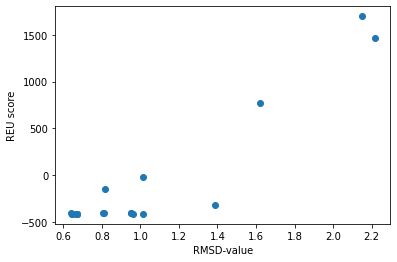

In [3]:
import matplotlib.pylab as plt
plt.scatter(RMSD_list,score_list)
plt.xlabel("RMSD-value")
plt.ylabel("REU score")

In [17]:
score_list

[-16.752860004350055,
 -503.4506458058428,
 -357.10948472456266,
 -485.4353306161962,
 44.21793585279977,
 -493.0614331142193,
 -219.28085171015925,
 -493.02531032496756,
 721.8725037241123,
 -501.1432352305543]

In [18]:
CA_rmsd(enzyme_pose,referencePose)

6.173908233642578

In [19]:
initial_energy

-651.7278206345007